In [2]:
import numpy as np
import pandas as pd

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


stop_words = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import pandas as pd

input_file = "/content/IMDB_Dataset.csv"
output_file = "/content/IMDB_Dataset_cleaned.csv"

# Open the input file and clean malformed lines
with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
    for line in infile:
        # Check if the line has an odd number of quotes
        if line.count('"') % 2 == 0:
            outfile.write(line)

# Read the cleaned CSV file
try:
    df = pd.read_csv(output_file, engine='python')
    print(df.head())
except pd.errors.ParserError as e:
    print(f"Error parsing cleaned file: {e}")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2417 non-null   object
 1   sentiment  2417 non-null   object
dtypes: object(2)
memory usage: 37.9+ KB


In [6]:
df.describe().T

,count,unique,top,freq
review,2417,2417,This picture for me scores very highly as it i...,1
sentiment,2417,2,positive,1226


In [7]:
#sentiment count:
df['sentiment'].value_counts()

sentiment
positive    1226
negative    1191
Name: count, dtype: int64

In [8]:
df['review'].str.len()

0       1761
1        998
2        926
3        748
4       1317
        ... 
2412    1689
2413    1356
2414     760
2415     823
2416     663
Name: review, Length: 2417, dtype: int64

Our dataset set is balanced. Next, We’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the movie's review.

<Axes: >

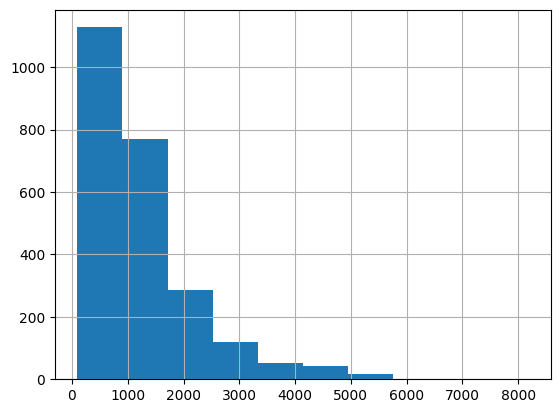

In [9]:
df['review'].str.len().hist()


The histogram shows that reviews range from 10 to 14000 characters and generally, it is between 10 to 1500 characters.

Now, we will move on the histogram for positive review and negative review respectively. Let's plot!

Text(0.5, 1.0, 'Negative Reviews')

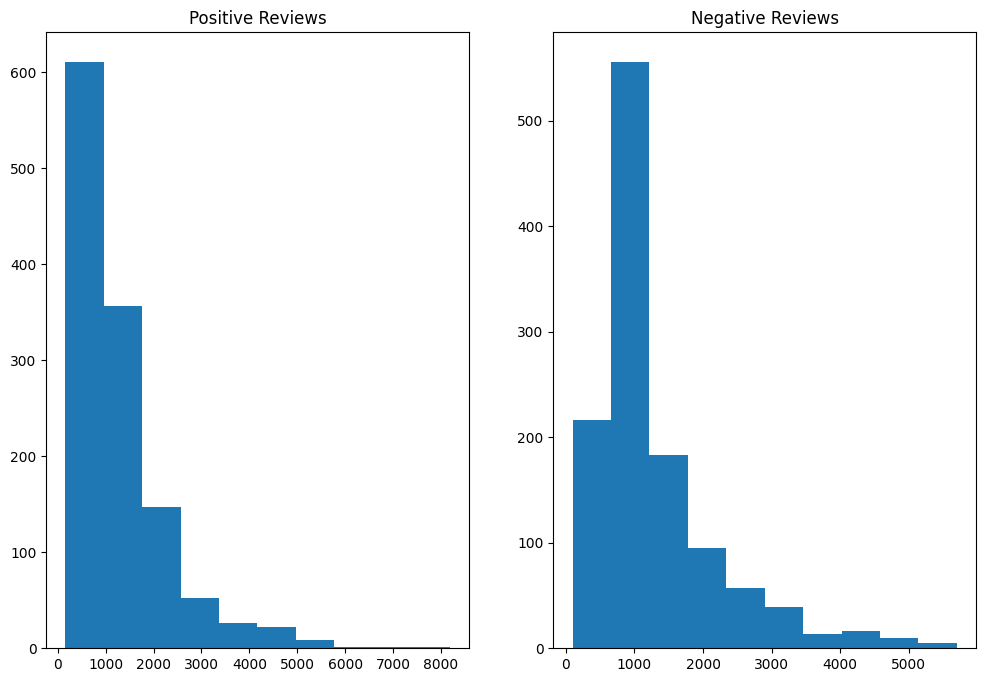

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df[df['sentiment']=='positive']['review'].str.len())
ax1.set_title( 'Positive Reviews')
ax2.hist(df[df['sentiment']=='negative']['review'].str.len())
ax2.set_title( 'Negative Reviews')

we can observe some insights from the graph above:
- In general, people comment less word in the positive review to compare with negative review
- However the range of word for positive review are bigger than the range of negative review. It means in some cases, people give a long comments for excellent movies and people could less critise for bad movies

Before we move on to the next section: data preprocessing to clean the text data, we will make a wordcloud graph to show the most used words in large font and the least used words in small font in positive review and negative review

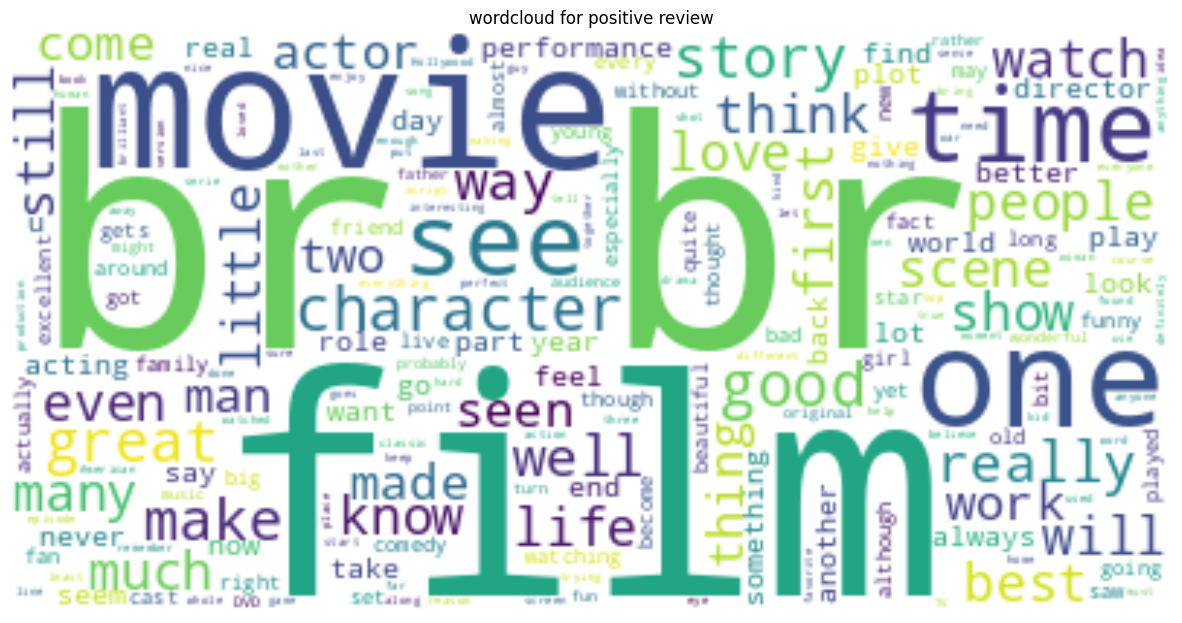

In [11]:
text = " ".join(i for i in df[df['sentiment']=='positive']['review'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for positive review')
plt.show()

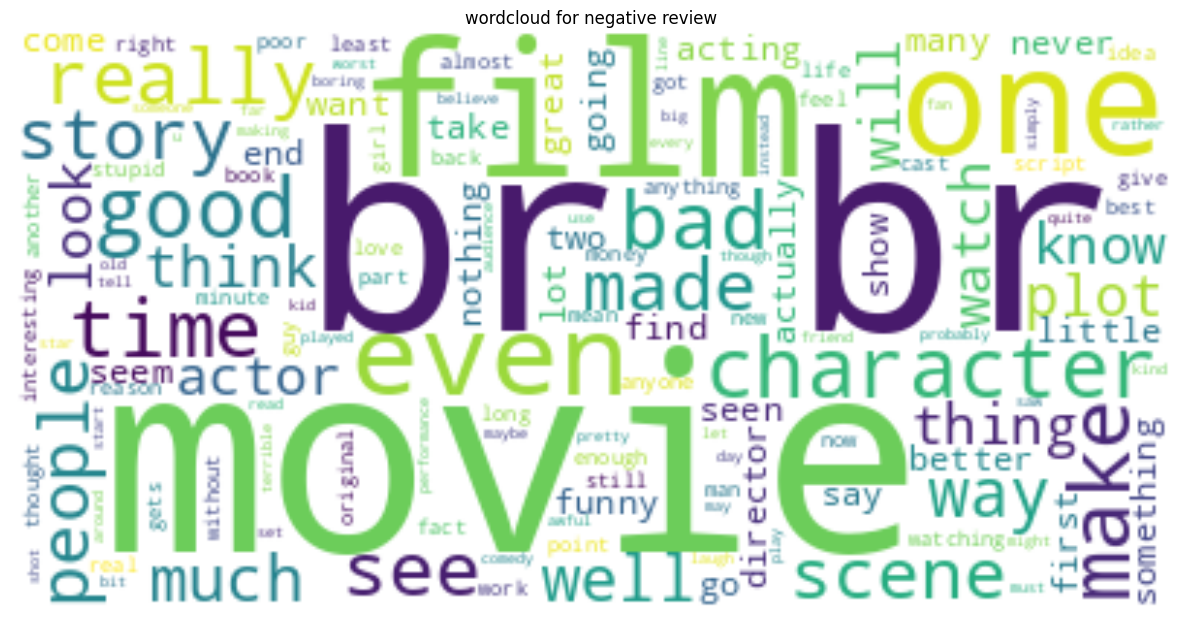

In [12]:
text = " ".join(i for i in df[df['sentiment']=='negative']['review'])
#stopwords = set(STOPWORDS)
wordcloud = WordCloud( background_color="white").generate(text)
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative review')
plt.show()

The wordcloud graphs in both negative and postitive comments don't show meaningful result.

That's is the reason why text preprosessing is needed.

Let's start the preproceesing process.

In [13]:
df.rename(columns={'review':'text'}, inplace = True)
df

,text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
2412,I will admit I didn't pay full attention to ev...,negative
2413,From all the bad comments about this movie and...,negative
2414,"Eh. This is a popcorn movie, nothing more. I w...",negative
2415,To say I was disappointed is an understatement...,negative


In [14]:
import re
import string

def cleaning(text):
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing numbers
    text = re.sub(r'<.*?>+', '', text) # removing special characters
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # removing punctuations
    text = re.sub(r'\n', '', text) # removing newlines
    text = re.sub(r'[’“”…]', '', text) # removing special characters

    # removing emoji
    emoji_pattern = re.compile(r"["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # removing short forms
    text = re.sub(r"isn't", 'is not', text)
    text = re.sub(r"he's", 'he is', text)
    text = re.sub(r"wasn't", 'was not', text)
    text = re.sub(r"there's", 'there is', text)
    text = re.sub(r"couldn't", 'could not', text)
    text = re.sub(r"won't", 'will not', text)
    text = re.sub(r"they're", 'they are', text)
    text = re.sub(r"she's", 'she is', text)
    text = re.sub(r"There's", 'there is', text)
    text = re.sub(r"wouldn't", 'would not', text)
    text = re.sub(r"haven't", 'have not', text)
    text = re.sub(r"That's", 'That is', text)
    text = re.sub(r"you've", 'you have', text)
    text = re.sub(r"He's", 'He is', text)
    text = re.sub(r"what's", 'what is', text)
    text = re.sub(r"weren't", 'were not', text)
    text = re.sub(r"we're", 'we are', text)
    text = re.sub(r"hasn't", 'has not', text)
    text = re.sub(r"you'd", 'you would', text)
    text = re.sub(r"shouldn't", 'should not', text)
    text = re.sub(r"let's", 'let us', text)
    text = re.sub(r"they've", 'they have', text)
    text = re.sub(r"You'll", 'You will', text)
    text = re.sub(r"i'm", 'i am', text)
    text = re.sub(r"we've", 'we have', text)
    text = re.sub(r"it's", 'it is', text)
    text = re.sub(r"don't", 'do not', text)
    text = re.sub(r"that´s", 'that is', text)
    text = re.sub(r"I´m", 'I am', text)
    text = re.sub(r"it’s", 'it is', text)
    text = re.sub(r"she´s", 'she is', text)
    text = re.sub(r"he’s'", 'he is', text)
    text = re.sub(r'I’m', 'I am', text)
    text = re.sub(r'I’d', 'I did', text)
    text = re.sub(r"he’s'", 'he is', text)
    text = re.sub(r'there’s', 'there is', text)

    return text

# Assuming df is your DataFrame
dt = df['text'].apply(cleaning)


In [15]:
df['sentiment']

0       positive
1       positive
2       positive
3       negative
4       positive
          ...   
2412    negative
2413    negative
2414    negative
2415    negative
2416    positive
Name: sentiment, Length: 2417, dtype: object

In [16]:
dt = pd.DataFrame(dt)
dt['sentiment']=df['sentiment']
dt

,text,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
2412,i will admit i didnt pay full attention to eve...,negative
2413,from all the bad comments about this movie and...,negative
2414,eh this is a popcorn movie nothing more i watc...,negative
2415,to say i was disappointed is an understatement...,negative


In [17]:
# remove stop word:
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [18]:
dt

,text,sentiment,no_sw
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...
...,...,...,...
2412,i will admit i didnt pay full attention to eve...,negative,admit pay full attention film honest mattered ...
2413,from all the bad comments about this movie and...,negative,comments movie add feel australians weaklings ...
2414,eh this is a popcorn movie nothing more i watc...,negative,popcorn movie watched bunch friends view horro...
2415,to say i was disappointed is an understatement...,negative,disappointed understatement amateur film made ...


In [19]:
#Working with the most Frequent Words:
from collections import Counter
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,movie,4006
1,film,3568
2,story,1036
3,time,1021
4,great,813
5,movies,784
6,make,744
7,made,725
8,films,708
9,characters,699


In [20]:
px.bar(temp, x="count", y="word", title='Commmon Words in Text', orientation='h',
             width=700, height=700)


In [21]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
dt["wo_stopfreq"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))
dt.head()

,text,sentiment,no_sw,wo_stopfreq
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...,wonderful spend hot summer weekend sitting air...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...


In [22]:
dt['no_sw'].loc[5]

'probably alltime favorite movie story selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [23]:
dt['wo_stopfreq'].loc[5]

'probably alltime favorite selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

In [24]:
# Lemmatization: Lemmatization is converting the word to its base form or lemma by removing affixes from the inflected words.
# It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.
import nltk

# Download the wordnet corpus
nltk.download('wordnet')


wordnet_lem = WordNetLemmatizer()

dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(wordnet_lem.lemmatize)
dt

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,sentiment,no_sw,wo_stopfreq,wo_stopfreq_lem
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...,wonderful production filming technique unassum...,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...,wonderful spend hot summer weekend sitting air...,wonderful spend hot summer weekend sitting air...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...,petter matteis love money visually stunning wa...
...,...,...,...,...,...
2412,i will admit i didnt pay full attention to eve...,negative,admit pay full attention film honest mattered ...,admit pay full attention honest mattered basic...,admit pay full attention honest mattered basic...
2413,from all the bad comments about this movie and...,negative,comments movie add feel australians weaklings ...,comments add feel australians weaklings instea...,comments add feel australians weaklings instea...
2414,eh this is a popcorn movie nothing more i watc...,negative,popcorn movie watched bunch friends view horro...,popcorn watched bunch friends view horror dial...,popcorn watched bunch friends view horror dial...
2415,to say i was disappointed is an understatement...,negative,disappointed understatement amateur film made ...,disappointed understatement amateur profession...,disappointed understatement amateur profession...


### Now, the data is clean! we can move to the next step: Navie_Bayes Modelling!

Tokenization

In [25]:
# create the cleaned data for the train-test split:
nb= dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns=['sentiment', 'review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

,sentiment,review
0,1,reviewers mentioned watching oz episode youll ...
1,1,wonderful production filming technique unassum...
2,1,wonderful spend hot summer weekend sitting air...
3,0,basically family boy jake thinks zombie closet...
4,1,petter matteis love money visually stunning wa...
...,...,...
2412,0,admit pay full attention honest mattered basic...
2413,0,comments add feel australians weaklings instea...
2414,0,popcorn watched bunch friends view horror dial...
2415,0,disappointed understatement amateur profession...


In [26]:
tokenized_review=nb['review'].apply(lambda x: x.split())
tokenized_review.head(5)

0    [reviewers, mentioned, watching, oz, episode, ...
1    [wonderful, production, filming, technique, un...
2    [wonderful, spend, hot, summer, weekend, sitti...
3    [basically, family, boy, jake, thinks, zombie,...
4    [petter, matteis, love, money, visually, stunn...
Name: review, dtype: object

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(nb['review'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Train-Test-Split

In [28]:
from sklearn.model_selection import train_test_split
X=text_counts
y=nb['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

We will now split the data for training and testing to check how well our model has performed.

Also we will randomize the data in case our data includes all positive first and then all negative or some other kind of bias.

We will use: scikit_learn's train_test_split() for splitting the text_count (which contains our X) and dataset['Sentiment'] (this contains Y).

 **Naive Bayes Modelling**

In this section, we will go through different Navies Bayes Model: ComplementNB, MultinatinominalNB, BernoulliNB and see how accuracy each model can be:

### a) Complement NB model:

In [29]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


ComplementNB model accuracy is 81.82%
------------------------------------------------
Confusion Matrix:
     0    1
0  202   44
1   44  194
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       246
           1       0.82      0.82      0.82       238

    accuracy                           0.82       484
   macro avg       0.82      0.82      0.82       484
weighted avg       0.82      0.82      0.82       484



Interpret the result:

- ### Accuracy score:
is 86.33 % for the complementNB model. for each  of 100 total number of prediction, in average, our model can predict 86 cases correctly

-  The confusion matrix:
* True Positive: The actual value was 4349 negative reviews  and the model predicted 4349 negative reviews
* True Negative: The actual value was 4284 positive reviews and the model predict 4248 negative reviews
* False Positive: The actual values was 628 postive reviews and the model predicted 628 negative reviews
* False Negative: The actual values was 739 negative reviews and the model preditced 739 positive reviews

- Classification Report:

* ### Precision:
- Negative review: the ratio correctly predicted negative review observations to the total predicted negative review observations is 0.85
- Positive review: the ratio correctly predicted positive review observations to the total predicted positive review observations is 0.87

* ### Recall:
- Negative review: the ratio of correctly predicted negative review observations to the all observations in actual class is 0.87
- Positive review: the ratio of correctly predicted positive review observations to the all observations in actual class is 0.85

* F1 Score is the weighted average of Precision and Recall. In both case positive and negative review, F1 scores are equal 0.86

We can apply the same interpretation for the following models


### b) Mutilnominal NB model:

In [30]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 82.02%
------------------------------------------------
Confusion Matrix:
     0    1
0  202   44
1   43  195
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       246
           1       0.82      0.82      0.82       238

    accuracy                           0.82       484
   macro avg       0.82      0.82      0.82       484
weighted avg       0.82      0.82      0.82       484



### c) Bernoulli NB model:

In [31]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

BernoulliNB model accuracy = 82.85%
------------------------------------------------
Confusion Matrix:
     0    1
0  207   39
1   44  194
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       246
           1       0.83      0.82      0.82       238

    accuracy                           0.83       484
   macro avg       0.83      0.83      0.83       484
weighted avg       0.83      0.83      0.83       484



### Plot Confusion Matrices:
Plot confusion matrix for CNB, MNB, BNB model:

In [32]:
!pip install --upgrade scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [33]:
import sklearn
print(sklearn.__version__)


1.2.2


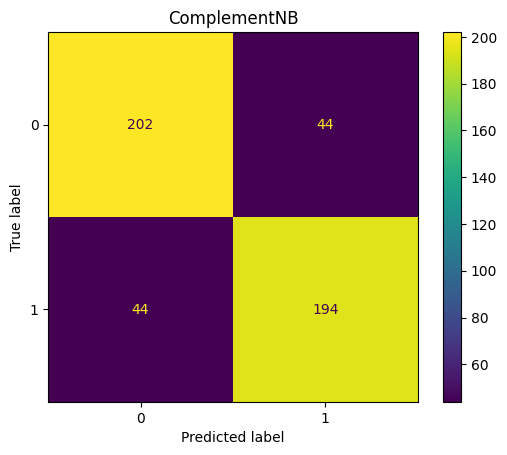

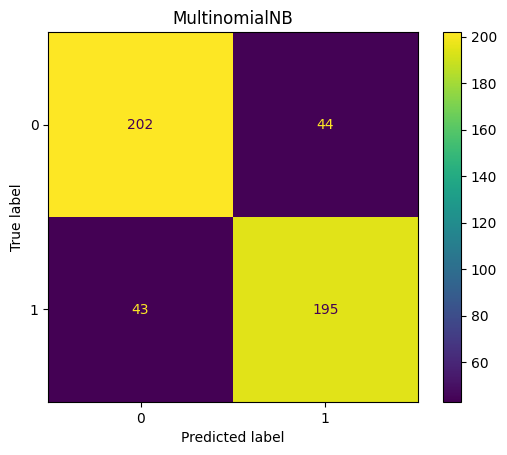

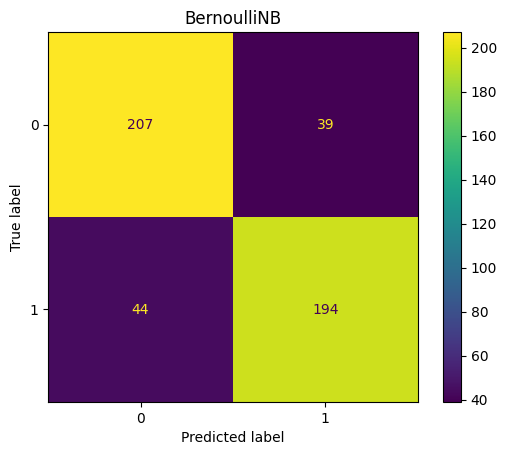

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

k = [CNB, MNB, BNB]
for model in k:
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_title(type(model).__name__)
    plt.show()


0.8867339618774338 0.8867339618774338 0.9087073853931816


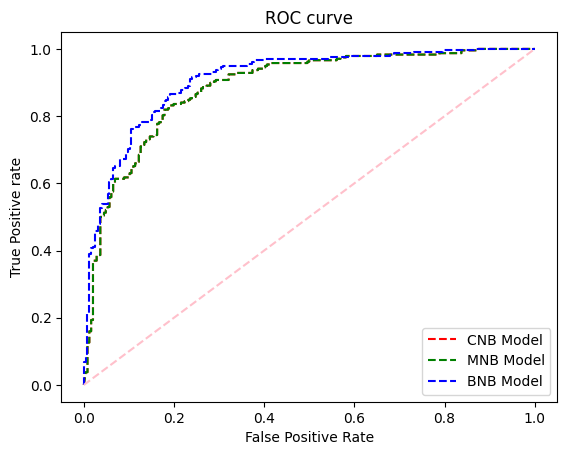

In [35]:
from sklearn.metrics import roc_curve

# predict probabilities for CNB, MNB, BNB models:
CNB_prob = CNB.predict_proba(X_test)
MNB_prob = MNB.predict_proba(X_test)
BNB_prob = BNB.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
from sklearn.metrics import roc_auc_score
auc_CNB = roc_auc_score(y_test, CNB_prob[:,1])
auc_MNB = roc_auc_score(y_test, MNB_prob[:,1])
auc_BNB = roc_auc_score(y_test, BNB_prob[:,1])
print(auc_CNB, auc_MNB,auc_BNB)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## 4.6 Trying different n-grams:


### a) Bigram: ngram_range = (2,2)

In [36]:

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_twograms = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
text_counts_twograms = cv_twograms.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_twograms, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

model accuracy is 67.77%


### b) Trigram: ngram_range= (3,3)¶

In [37]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_threegrams = CountVectorizer(stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts_threegrams = cv_threegrams.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_threegrams, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')


model accuracy is 50.83%


**TF-IDF : Term Frequency-Inverse Document Frequency**

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(nb['review'])

In [39]:
#splitting the data in test and training
#from sklearn.model_selection() import train_test_split()
x_train, x_test, y_train, y_test = train_test_split(text_count_2, nb['sentiment'],test_size=0.20,random_state=30)


In [40]:
#fitting the model with MNB
MNB.fit(x_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(x_test), y_test)

print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')



accuracy_score_mnb = 82.23%


In [41]:
predicted_sentiments = pd.Series(MNB.predict(tfidf.transform(nb['review'])))
df['predicted_sentiment'] = predicted_sentiments.map({0: 'negative', 1: 'positive'})

In [42]:
#fitting the model with BNB
BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')


accuracy_score_bnb = 83.06%


In [43]:
# fitting the model with CNB
CNB.fit(x_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(x_test), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')

accuracy_score_cnb = 82.02%


In [44]:
import gensim
from gensim import corpora

# Further text cleaning (if needed)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Tokenizing and removing stop words
processed_docs = dt['wo_stopfreq'].map(preprocess)

# Creating a dictionary
dictionary = corpora.Dictionary(processed_docs)

# Creating a corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(dictionary)
print(corpus[:1])


Dictionary<32589 unique tokens: ['accustomed', 'agenda', 'agreements', 'appeal', 'audiences']...>
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 3), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), 

In [45]:
import gensim
from gensim import corpora

# Further text cleaning (if needed)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Tokenizing and removing stop words
processed_docs = dt['wo_stopfreq'].map(preprocess)

# Creating a dictionary
dictionary = corpora.Dictionary(processed_docs)

# Assuming nb['sentiment'] contains the predicted sentiment labels from Naive Bayes
# Create a new DataFrame for negative and positive reviews
df_negative = dt[dt['sentiment'] == 'negative']
df_positive = dt[dt['sentiment'] == 'positive']

# Tokenizing and removing stop words for negative reviews
processed_docs_negative = df_negative['wo_stopfreq'].map(preprocess)

# Creating a dictionary and corpus for negative reviews
dictionary_negative = corpora.Dictionary(processed_docs_negative)
corpus_negative = [dictionary_negative.doc2bow(doc) for doc in processed_docs_negative]

# Perform LDA topic modeling for negative reviews
lda_model_negative = gensim.models.LdaMulticore(corpus_negative,
                                                id2word=dictionary_negative,
                                                num_topics=10,
                                                random_state=100,
                                                chunksize=150,
                                                passes=20,
                                                per_word_topics=True)

# Display the topics for negative reviews
topics_negative = lda_model_negative.print_topics(num_words=10)
for topic in topics_negative:
    print(topic)

# Print statement for positive reviews
print("LDA is not required for positive reviews.")


(0, '0.003*"laurel" + 0.003*"rourke" + 0.003*"stan" + 0.003*"mickey" + 0.003*"unimaginative" + 0.003*"entertain" + 0.002*"hardy" + 0.002*"companies" + 0.002*"janet" + 0.002*"current"')
(1, '0.005*"stephen" + 0.003*"build" + 0.003*"beethoven" + 0.002*"ants" + 0.002*"bang" + 0.002*"talky" + 0.002*"baseball" + 0.002*"depression" + 0.002*"laid" + 0.002*"roberts"')
(2, '0.007*"plot" + 0.006*"acting" + 0.005*"watch" + 0.004*"real" + 0.004*"watching" + 0.004*"scenes" + 0.004*"things" + 0.004*"scene" + 0.004*"minutes" + 0.004*"actors"')
(3, '0.007*"funny" + 0.005*"original" + 0.004*"years" + 0.003*"character" + 0.003*"actors" + 0.003*"find" + 0.003*"house" + 0.003*"cast" + 0.003*"stupid" + 0.003*"comedy"')
(4, '0.007*"woman" + 0.004*"cannibal" + 0.003*"young" + 0.002*"tony" + 0.002*"deals" + 0.002*"years" + 0.002*"awards" + 0.002*"lover" + 0.002*"floor" + 0.002*"women"')
(5, '0.004*"back" + 0.003*"worst" + 0.003*"werewolf" + 0.002*"american" + 0.002*"high" + 0.002*"part" + 0.002*"funny" + 0.00

In [46]:
# Evaluate the coherence score of the topic model
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_negative, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda:.2f}')

Coherence Score: 0.67


https://www.jigsawacademy.com/blogs/ai-ml/bayes-theorem-in-machine-learning

https://www.upgrad.com/blog/bayes-theorem-in-machine-learning/

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

https://github.com/DrManishSharma/NLP/blob/master/SentiAnalysis.ipynb

In [47]:
# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus,
                                       id2word=dictionary,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


In [48]:
# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.007*"young" + 0.006*"match" + 0.006*"life" + 0.006*"world" + 0.004*"japanese" + 0.003*"posey" + 0.003*"joan" + 0.003*"police" + 0.003*"country" + 0.003*"indian"')
(1, '0.008*"pleasure" + 0.007*"emotion" + 0.006*"occasions" + 0.006*"proud" + 0.005*"officer" + 0.005*"butchered" + 0.005*"busy" + 0.005*"infected" + 0.005*"earthquake" + 0.005*"lacking"')
(2, '0.008*"hardy" + 0.008*"gibson" + 0.007*"graves" + 0.006*"laurel" + 0.006*"mexico" + 0.006*"kitchen" + 0.004*"precisely" + 0.004*"stan" + 0.004*"consideration" + 0.003*"assistant"')
(3, '0.011*"cover" + 0.008*"aliens" + 0.007*"alien" + 0.006*"born" + 0.006*"market" + 0.006*"kelly" + 0.005*"tradition" + 0.005*"ironic" + 0.005*"scores" + 0.005*"blonde"')
(4, '0.006*"watch" + 0.006*"acting" + 0.005*"plot" + 0.005*"character" + 0.004*"love" + 0.004*"funny" + 0.004*"scenes" + 0.004*"show" + 0.004*"real" + 0.004*"watching"')
(5, '0.007*"rings" + 0.006*"drives" + 0.006*"continuity" + 0.006*"amitabh" + 0.005*"lord" + 0.005*"underrated" +

In [49]:
import pandas as pd

# Adding a topic column to the dataframe
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num, topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                sent_topics_df = pd.concat([sent_topics_df, row_df], ignore_index=True)
            else:
                break

    contents = pd.Series(texts).reset_index(drop=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=dt['wo_stopfreq'])
df_topic_sents_keywords.head()


,Dominant_Topic,Perc_Contribution,Topic_Keywords,wo_stopfreq
0,4,0.6150,"watch, acting, plot, character, love, funny, s...",reviewers mentioned watching oz episode youll ...
1,4,0.6345,"watch, acting, plot, character, love, funny, s...",wonderful production filming technique unassum...
2,4,0.7557,"watch, acting, plot, character, love, funny, s...",wonderful spend hot summer weekend sitting air...
3,4,0.6781,"watch, acting, plot, character, love, funny, s...",basically family boy jake thinks zombie closet...
4,4,0.9873,"watch, acting, plot, character, love, funny, s...",petter matteis love money visually stunning wa...


In [50]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Tokenize and remove stop words
def extract_keywords(text, num=10):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    fdist = FreqDist(words)
    return fdist.most_common(num)

# Extracting keywords from a sample text
sample_text = df['text'][0]
keywords = extract_keywords(sample_text)
print(keywords)


[('oz', 6), ('br', 6), ('violence', 4), ('show', 3), ('prison', 3), ('forget', 3), ('watching', 2), ('episode', 2), ('struck', 2), ('city', 2)]


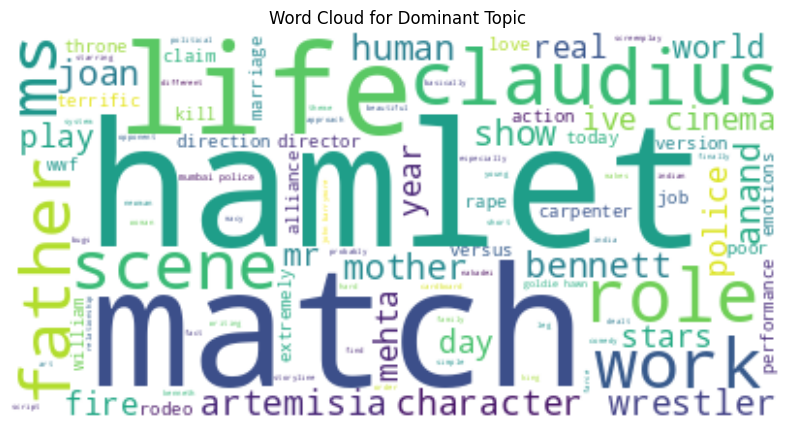

In [51]:
from wordcloud import WordCloud

# Generating word cloud for the dominant topic
dominant_topic = df_topic_sents_keywords[df_topic_sents_keywords.Dominant_Topic == 0]
text = ' '.join(dominant_topic['wo_stopfreq'])
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Dominant Topic')
plt.show()


In [52]:
# Evaluate the coherence score of the topic model
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda:.2f}')

Coherence Score: 0.60


In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [54]:
# Tokenize the text
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dt['wo_stopfreq'])
sequences = tokenizer.texts_to_sequences(dt['wo_stopfreq'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)


In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'df' is your DataFrame and 'wo_stopfreq' is the cleaned text column

# Parameters
max_words = 5000  # Adjust based on your dataset
max_len = 100  # Adjust based on your dataset

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(nb['review'])
sequences = tokenizer.texts_to_sequences(nb['review'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nb['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64))  # Removed input_length
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")
accuracy_lstm = metrics.accuracy_score(y_test, y_pred_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_lstm)))
print('Classification Report:')
print(classification_report(y_test, y_pred_lstm))


Epoch 1/5
25/25 [==============================] - 25s 333ms/step - loss: 0.6918 - accuracy: 0.5427 - val_loss: 0.6827 - val_accuracy: 0.5633
Epoch 2/5
25/25 [==============================] - 5s 215ms/step - loss: 0.5553 - accuracy: 0.7193 - val_loss: 0.4928 - val_accuracy: 0.7778
Epoch 3/5
25/25 [==============================] - 4s 157ms/step - loss: 0.1648 - accuracy: 0.9502 - val_loss: 0.5499 - val_accuracy: 0.8036
Epoch 4/5
25/25 [==============================] - 3s 140ms/step - loss: 0.0610 - accuracy: 0.9832 - val_loss: 0.5426 - val_accuracy: 0.7778
Epoch 5/5
16/16 [==============================] - 1s 11ms/step
Bidirectional LSTM Model Accuracy: 72.31%
Confusion Matrix:
     0    1
0  142  109
1   25  208
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.57      0.68       251
           1       0.66      0.89      0.76       233

    accuracy                           0.72       484
   macro avg       0.75      0.73 

In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'df' is your DataFrame and 'nb' is the cleaned text column with 'review' and 'sentiment'

# Parameters
max_words = 20000  # Adjust based on your dataset size and vocabulary
max_len = 100  # Adjust based on your dataset

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(nb['review'])
sequences = tokenizer.texts_to_sequences(nb['review'])

# Check the distribution of sequence lengths
seq_lengths = [len(seq) for seq in sequences]
print(f'Max sequence length: {max(seq_lengths)}')
print(f'Average sequence length: {np.mean(seq_lengths)}')
print(f'Median sequence length: {np.median(seq_lengths)}')

# Adjust max_len based on the distribution (you can change 100 to another value if needed)
max_len = min(max(seq_lengths), 100)

padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nb['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64))  # Removed input_length
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")
accuracy_lstm = metrics.accuracy_score(y_test, y_pred_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_lstm)))
print('Classification Report:')
print(classification_report(y_test, y_pred_lstm))


Max sequence length: 425
Average sequence length: 78.22672734795201
Median sequence length: 56.0
Epoch 1/5
25/25 [==============================] - 14s 255ms/step - loss: 0.6915 - accuracy: 0.5097 - val_loss: 0.6824 - val_accuracy: 0.6512
Epoch 2/5
25/25 [==============================] - 5s 193ms/step - loss: 0.5091 - accuracy: 0.8448 - val_loss: 0.5616 - val_accuracy: 0.7339
Epoch 3/5
25/25 [==============================] - 4s 170ms/step - loss: 0.1371 - accuracy: 0.9774 - val_loss: 0.5762 - val_accuracy: 0.7623
Epoch 4/5
25/25 [==============================] - 5s 186ms/step - loss: 0.0318 - accuracy: 0.9981 - val_loss: 1.0250 - val_accuracy: 0.7183
Epoch 5/5
16/16 [==============================] - 1s 11ms/step
Bidirectional LSTM Model Accuracy: 77.48%
Confusion Matrix:
     0    1
0  215   36
1   73  160
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       251
           1       0.82      0.69      0.75   

In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'df' is your DataFrame and 'nb' is the cleaned text column with 'review' and 'sentiment'

# Parameters
max_words = 20000  # Adjust based on your dataset size and vocabulary
max_len = 150  # Adjust based on your dataset and sequence length distribution
embedding_dim = 128  # Adjust embedding dimension based on experimentation
lstm_units = 32  # Adjust LSTM units based on experimentation
dropout_rate = 0.2 # Adjust dropout rate based on experimentation

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(nb['review'])
sequences = tokenizer.texts_to_sequences(nb['review'])

# Check the distribution of sequence lengths
seq_lengths = [len(seq) for seq in sequences]
print(f'Max sequence length: {max(seq_lengths)}')
print(f'Average sequence length: {np.mean(seq_lengths)}')
print(f'Median sequence length: {np.median(seq_lengths)}')

# Adjust max_len based on the distribution (you can change 150 to another value if needed)
max_len = min(max(seq_lengths), max_len)

padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nb['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")
accuracy_lstm = metrics.accuracy_score(y_test, y_pred_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_lstm)))
print('Classification Report:')
print(classification_report(y_test, y_pred_lstm))


Max sequence length: 425
Average sequence length: 78.22672734795201
Median sequence length: 56.0
Epoch 1/10
25/25 [==============================] - 13s 180ms/step - loss: 0.6897 - accuracy: 0.5382 - val_loss: 0.6737 - val_accuracy: 0.5685
Epoch 2/10
25/25 [==============================] - 3s 118ms/step - loss: 0.4383 - accuracy: 0.8157 - val_loss: 0.4693 - val_accuracy: 0.7700
Epoch 3/10
25/25 [==============================] - 3s 106ms/step - loss: 0.0927 - accuracy: 0.9845 - val_loss: 0.6972 - val_accuracy: 0.7752
Epoch 4/10
25/25 [==============================] - 3s 135ms/step - loss: 0.0093 - accuracy: 0.9994 - val_loss: 1.0185 - val_accuracy: 0.7519
Epoch 5/10
25/25 [==============================] - 4s 147ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 1.0235 - val_accuracy: 0.7674
Epoch 6/10
25/25 [==============================] - 3s 130ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0165 - val_accuracy: 0.7984
Epoch 7/10
25/25 [==============================] 

In [70]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from gensim.corpora import Dictionary
from gensim.models import LdaModel
# Filter negative reviews based on LSTM predictions
negative_reviews_indices = np.where(y_pred_lstm == 0)[0]
negative_reviews = nb.iloc[negative_reviews_indices]['review']

# Tokenize and preprocess negative reviews for LDA
negative_sequences = tokenizer.texts_to_sequences(negative_reviews)
negative_padded_sequences = pad_sequences(negative_sequences, maxlen=max_len)

# Create a reverse mapping from token index to word
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

# Convert tokenized sequences back to words
negative_reviews_words = [[reverse_word_index[token] for token in seq if token in reverse_word_index] for seq in negative_sequences]

# Build dictionary and corpus for LDA
negative_dictionary = Dictionary(negative_reviews_words)
negative_corpus = [negative_dictionary.doc2bow(doc) for doc in negative_reviews_words]

# Perform LDA on negative reviews
num_topics = 10  # You can adjust this based on your requirements
lda_model = LdaModel(corpus=negative_corpus, id2word=negative_dictionary, num_topics=num_topics, random_state=300, passes=100)

# Print topics for negative reviews
print('\nTopics for Negative Reviews:')
for idx, topic in lda_model.print_topics():
    print(f'Topic: {idx}')
    print(f'Words: {topic}\n')


Topics for Negative Reviews:
Topic: 0
Words: 0.005*"jimmy" + 0.004*"plot" + 0.003*"black" + 0.003*"scene" + 0.003*"life" + 0.003*"back" + 0.003*"tom" + 0.003*"rose" + 0.003*"director" + 0.003*"fred"

Topic: 1
Words: 0.004*"scenes" + 0.004*"plot" + 0.004*"work" + 0.003*"hamlet" + 0.003*"watch" + 0.003*"character" + 0.003*"claudius" + 0.003*"series" + 0.003*"comedy" + 0.003*"life"

Topic: 2
Words: 0.004*"plot" + 0.004*"character" + 0.004*"acting" + 0.003*"watch" + 0.003*"ive" + 0.003*"bit" + 0.003*"james" + 0.002*"scene" + 0.002*"young" + 0.002*"days"

Topic: 3
Words: 0.005*"watch" + 0.003*"find" + 0.003*"funny" + 0.003*"world" + 0.003*"life" + 0.003*"laugh" + 0.003*"comedy" + 0.003*"nice" + 0.003*"probably" + 0.003*"character"

Topic: 4
Words: 0.005*"azumi" + 0.004*"world" + 0.004*"family" + 0.003*"danton" + 0.003*"year" + 0.003*"funny" + 0.002*"read" + 0.002*"interesting" + 0.002*"actual" + 0.002*"side"

Topic: 5
Words: 0.006*"mario" + 0.005*"game" + 0.004*"back" + 0.004*"girls" + 0.0

In [71]:
# Calculate Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=negative_reviews_words, dictionary=negative_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nLDA Model Coherence Score: {coherence_lda}')


LDA Model Coherence Score: 0.3552733870485548
